In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plot_img(img):
    plt.figure(figsize=(10,7))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
part1_single_objects = "../COTSDataset/Part 1 - Single Objects"
part2_multiple_objects = "../COTSDataset/Part 2 - Multiple Objects"
part3_complex_background = "../COTSDataset/Part 3 - Complex Background"

In [4]:
img_path = os.path.join(part2_multiple_objects, "academic_book_no", "1_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "statues_no", "1_colour.jpeg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_7_mask.png")
# mask_path = os.path.join(part2_multiple_objects, "statues_no", "masks", "statues_no_3_colour_mask_1_mask.png")
mask = cv2.imread(mask_path)

In [5]:
# Extracting target bounding box from mask
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask.astype(np.uint8)
# Find contours in the mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty list to store bounding boxes
bounding_boxes = []

# Loop through the detected contours
for cnt in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Add the bounding box coordinates to the list
    bounding_boxes.append((x, y, x + w, y + h))

# Find the minimum and maximum coordinates to create a bounding box around all masks
x1, y1 = min(box[0] for box in bounding_boxes), min(box[1] for box in bounding_boxes)
x2, y2 = max(box[2] for box in bounding_boxes), max(box[3] for box in bounding_boxes)

# Create the target bounding box that encompasses all masks
target_bbox = np.array([x1, y1, x2, y2])

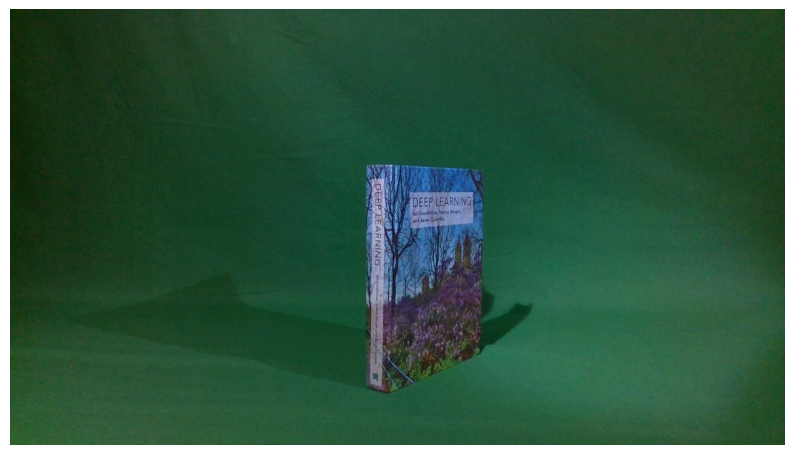

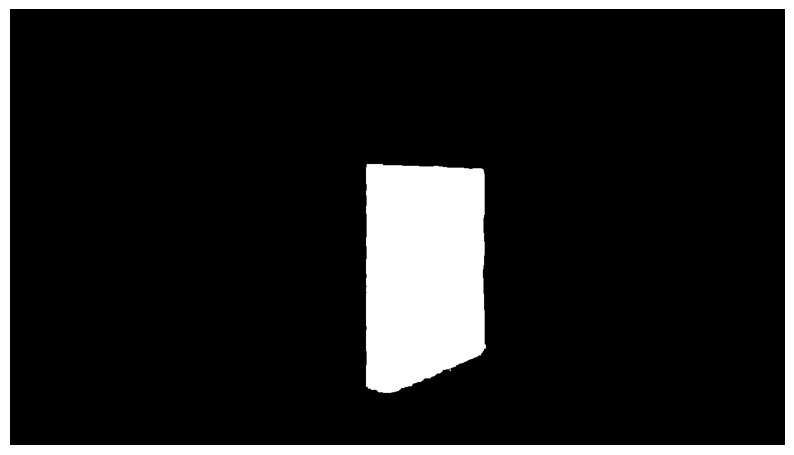

In [6]:
plot_img(img)
plot_img(mask)

In [7]:
from utils import *
from models import *
from env import *
from init import *
from agent import DQNAgent, DoubleDQNAgent, DuelingDQNAgent, DoubleDuelingDQNAgent

CUDA is available! Using GPU for computations.


In [8]:
env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox, render_mode="human")
_ = env.reset()
# PROBLEM WITH RENDERING

In [9]:
# _ = env.render()

In [10]:
# env.close()

In [11]:
# Creating the environment
# env = DetectionEnv(img, img, target_bbox) #, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)
# env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)
# _ = env.reset()

In [12]:
# env = DetectionEnv(img, img, target_bbox, feature_extractor=MobileNetV2FeatureExtractor(), target_size=MOBILENETV2_TARGET_SIZE)
# env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox, feature_extractor=MobileNetV2FeatureExtractor(), target_size=MOBILENETV2_TARGET_SIZE)
# _ = env.reset()

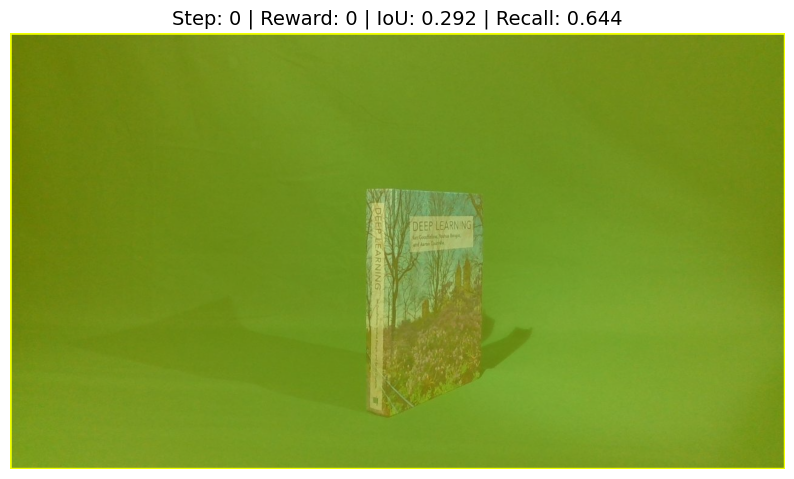

In [13]:
frame = env.display(do_display=True)

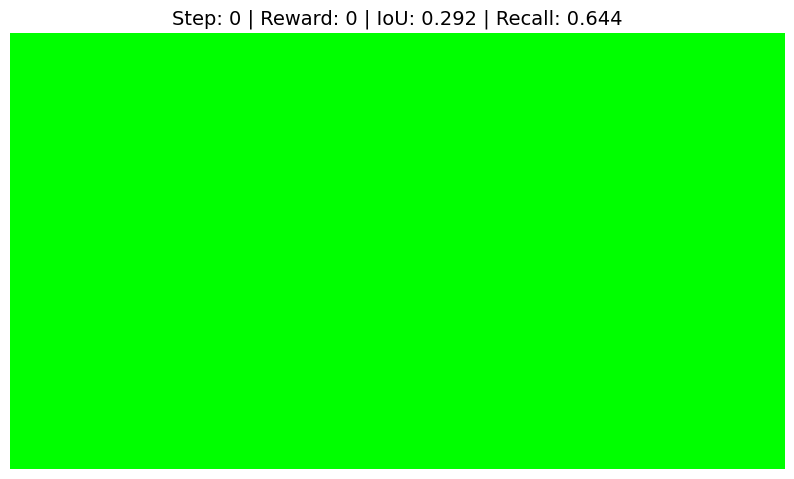

In [14]:
frame = env.display(do_display=True, mode='bbox')

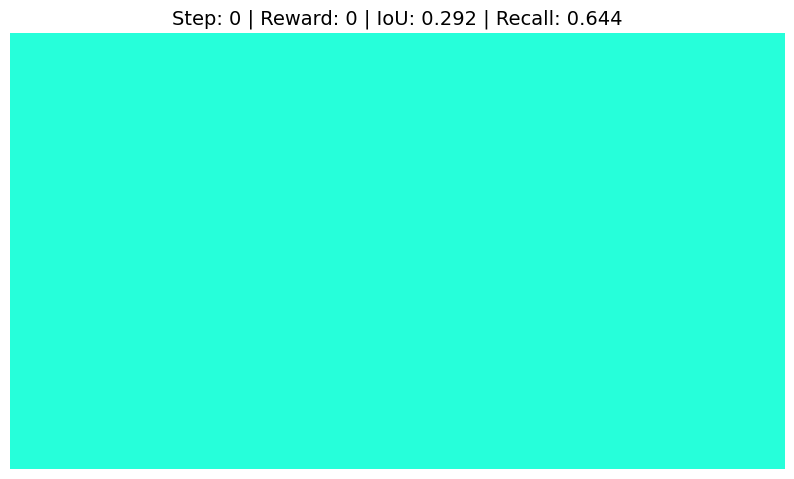

In [15]:
frame = env.display(do_display=True, mode='heatmap')

In [16]:
env.get_actions()

Actions:
0: Move right → 
1: Move left ←
2: Move up ↑
3: Move down ↓
4: Make bigger +
5: Make smaller -
6: Make fatter W
7: Make taller H
8: Trigger T


In [17]:
observation_space, info = env.reset()
print(observation_space)

[[0.0000000e+00 0.0000000e+00 1.2800000e+03 ... 2.3769828e-02
  1.9780377e-02 7.3685847e-02]]


In [18]:
env.observation_space

Box(0.0, 100.0, (2232,), float32)

Action: Make bigger +
Terminated:  False
Truncated:  False
Reward:  0.0
IoU 0.2922073903658053
Recall 0.6443358136473459


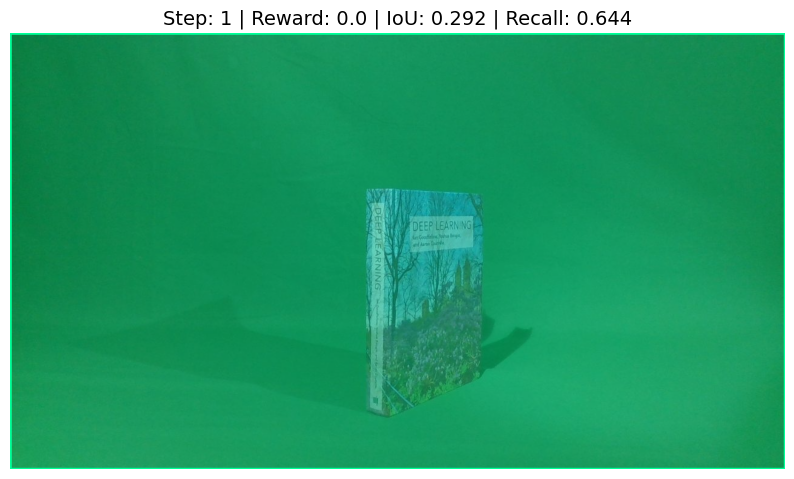

In [19]:
action = env.action_space.sample()

env.decode_action(action)

# Taking a step in the environment
next_state, reward, terminated, truncated, info = env.step(action)
print("Terminated: ", terminated)
print("Truncated: ", truncated)
print("Reward: ", reward)
print("IoU", info['iou'])
print("Recall", info['recall'])
_ = env.display(do_display=True, mode='image')

In [20]:
img_path2 = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img2 = cv2.imread(img_path2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

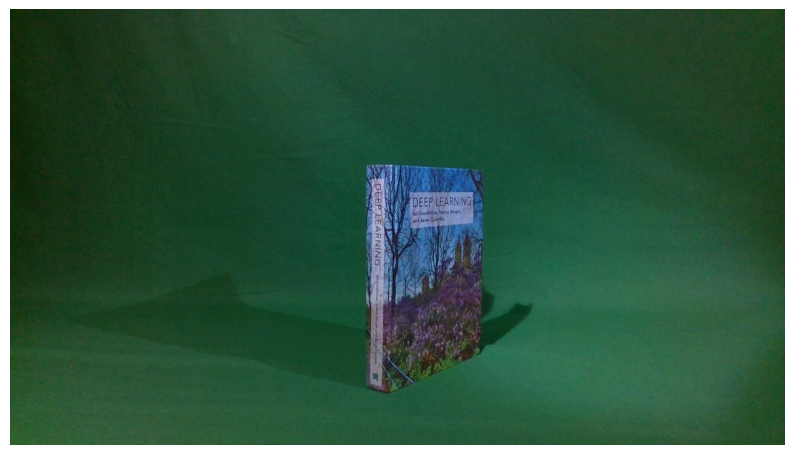

In [21]:
plot_img(img)

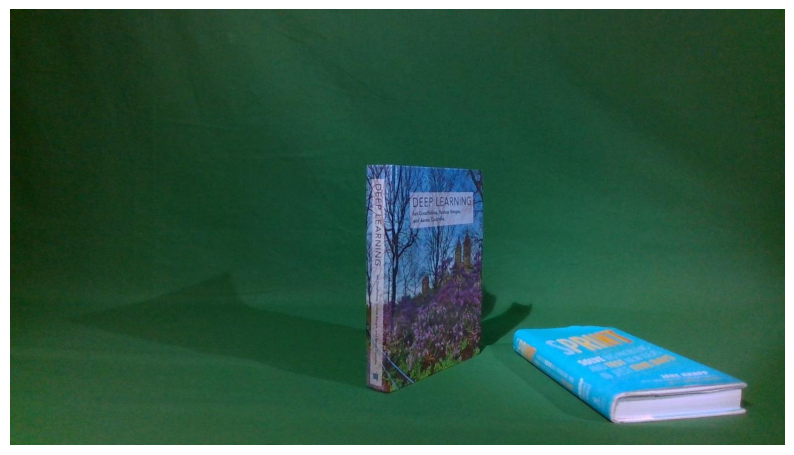

In [22]:
plot_img(img2)

In [23]:
def check(image1, image2):
    for i in range(len(image1)):
        for j in range(len(image1[0])):
            if image1[i][j] != image2[i][j]:
                print("Not equal")
                break

In [24]:
image1, _ = env.reset(image=img)
image2, _ = env.reset(image=img2)
check(image1, image2)

Not equal


In [25]:
image1, _ = env.reset(image=img)
image2, _ = env.reset(image=img)
check(image1, image2)

#### DQN Agent

In [26]:
# # Setting name
# name = "Normal DQN"

# # Creating the Replay_Buffer
# replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# # Creating the DQN agent
# dqn_agent = DQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# # Running the agent
# dqn_agent.run()

# # Retrieving the episode info
# dqn_episode_info = dqn_agent.get_episode_info()

# # Printing the time taken to train the agent
# print("Time taken to train the agent: {:.2f} seconds".format(dqn_episode_info["eps_duration"]))

# # Saving the model
# dqn_agent.save(path="models/" + name)

In [27]:
# Setting name
name = "Normal DQN"

# Creating the Replay_Buffer
replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# Creating the DQN agent
dqn_agent = DQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# Running the agent
dqn_agent.load(path="models/" + name)
dqn_agent.epsilon = 0.0

#### Double DQN Agent

In [28]:
# # Setting name
# name = "Double DQN"

# # Creating the Replay_Buffer
# replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# # Creating the Double DQN agent
# dqn_agent = DoubleDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# # Running the agent
# dqn_agent.run()

# # Retrieving the episode info
# dqn_episode_info = dqn_agent.get_episode_info()

# # Printing the time taken to train the agent
# print("Time taken to train the agent: {:.2f} seconds".format(dqn_episode_info["eps_duration"]))

# # Saving the model
# dqn_agent.save(path="models/" + name)

In [29]:
# # Setting name
# name = "Double DQN"

# # Creating the Replay_Buffer
# replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# # Creating the Double DQN agent
# dqn_agent = DoubleDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# # Running the agent
# dqn_agent.load(path="models/" + name)
# dqn_agent.epsilon = 0.0

#### Dueling DQN Agent

In [30]:
# # Setting name
# name = "Dueling DQN"

# # Creating the Replay_Buffer
# replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# # Creating the Dueling DQN agent
# dqn_agent = DuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# # Running the agent
# dqn_agent.run()

# # Retrieving the episode info
# dqn_episode_info = dqn_agent.get_episode_info()

# # Printing the time taken to train the agent
# print("Time taken to train the agent: {:.2f} seconds".format(dqn_episode_info["eps_duration"]))

# # Saving the model
# dqn_agent.save(path="models/" + name)

In [31]:
# # Setting name
# name = "Dueling DQN"

# # Creating the Replay_Buffer
# replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# # Creating the Dueling DQN agent
# dqn_agent = DuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# # Running the agent
# dqn_agent.load(path="models/" + name)
# dqn_agent.epsilon = 0.0

#### Double Dueling DQN Agent

In [32]:
# # Setting name
# name = "Double Dueling DQN"

# # Creating the Replay_Buffer
# replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# # Creating the Double Dueling DQN agent
# dqn_agent = DoubleDuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# # Running the agent
# dqn_agent.run()

# # Retrieving the episode info
# dqn_episode_info = dqn_agent.get_episode_info()

# # Printing the time taken to train the agent
# print("Time taken to train the agent: {:.2f} seconds".format(dqn_episode_info["eps_duration"]))

# # Saving the model
# dqn_agent.save(path="models/" + name)

In [33]:
# # Setting name
# name = "Double Dueling DQN"

# # Creating the Replay_Buffer
# replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# # Creating the Double Dueling DQN agent
# dqn_agent = DoubleDuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# # Running the agent
# dqn_agent.load(path="models/" + name)
# dqn_agent.epsilon = 0.0

In [34]:
dqn_episode_info = dqn_agent.get_episode_info()

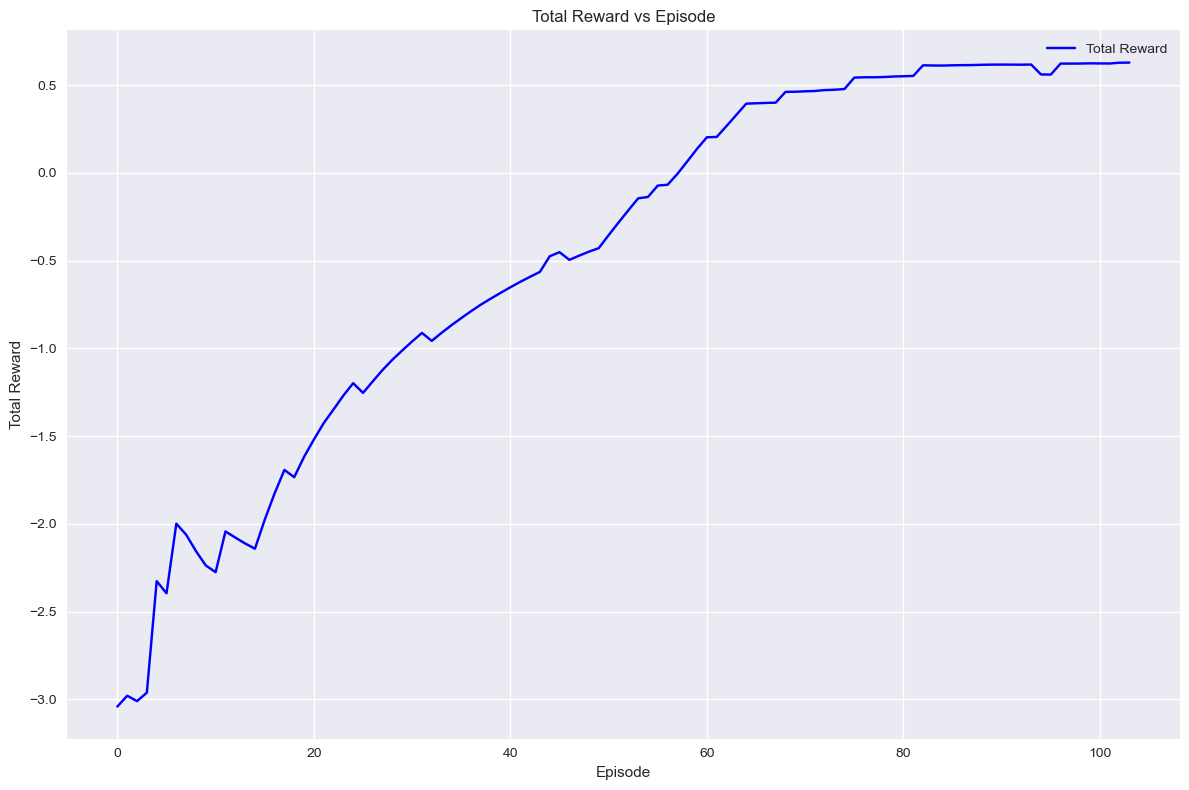

In [35]:
rewards_list = dqn_episode_info["episode_avg_rewards"]
# Plotting the rewards
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
plt.plot(rewards_list, label='Total Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

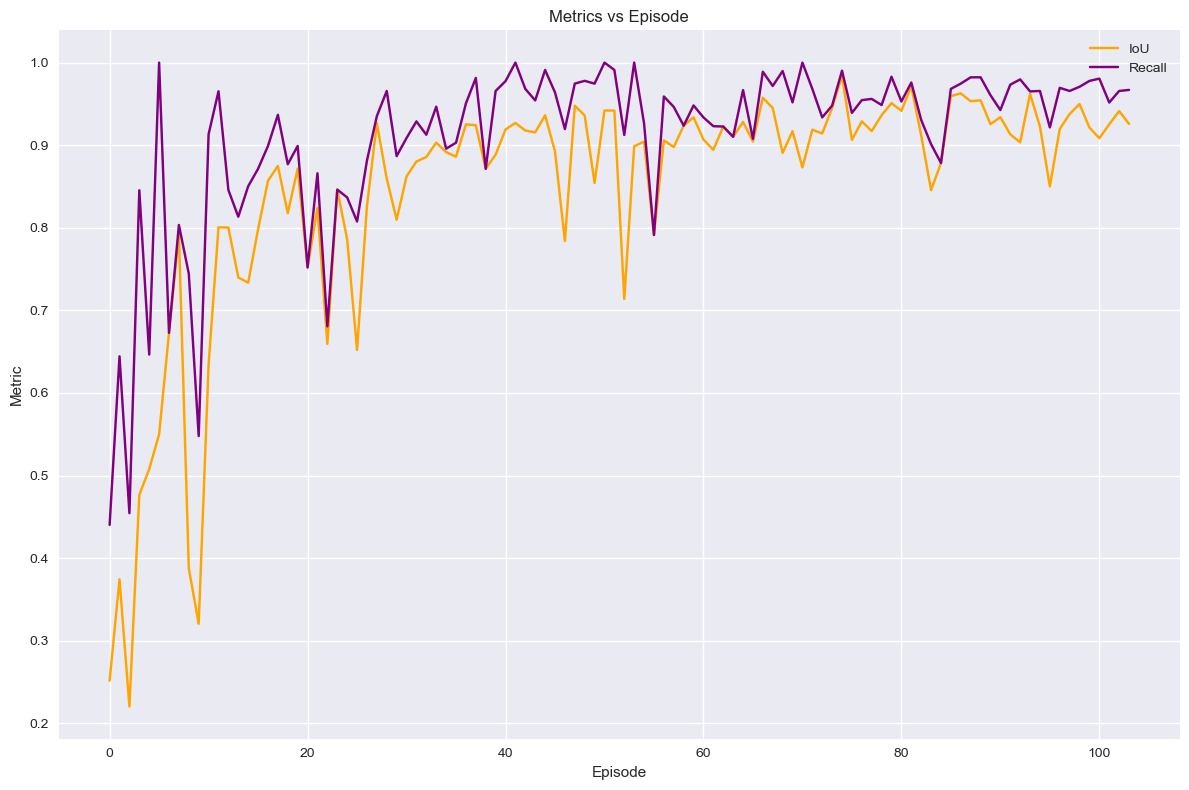

In [36]:
iou_list = dqn_episode_info["iou"]
recall_list = dqn_episode_info["recall"]

plt.figure(figsize=(12,8))
plt.style.use('seaborn')
plt.plot(iou_list, label='IoU', color='orange')
plt.plot(recall_list, label='Recall', color='purple')
plt.xlabel('Episode')
plt.ylabel('Metric')
plt.title('Metrics vs Episode')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [37]:
# Predicting the bounding box
env.reset()
# env.display(do_display=True, mode='image')
state = env.get_state()

total_reward = 0

terminated = False
truncated = False

while True:
    action = dqn_agent.select_action(state)
    next_state, _, terminated, truncated, info = env.step(action)
    env.decode_action(action)
    done = truncated or terminated

    state = next_state
    # env.display(do_display=True, mode='image')
    if done:
        break

print(f"Total Reward: {total_reward}, IoU: {info['iou']}, Recall: {info['recall']}, Steps: {env.step_count}")

Action: Move right →
Action: Make smaller -


Action: Move down ↓
Action: Make smaller -
Action: Make smaller -
Action: Make smaller -
Action: Make taller H
Action: Make taller H
Action: Make taller H
Action: Move down ↓
Action: Make bigger +
Action: Make taller H
Action: Make taller H
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
Action: Move right →
Action: Move left ←
T

In [38]:
# env.test()

In [39]:
dqn_agent.test(file_path=name)#, video_filename='test.mp4')

Video saved to: Normal DQN\test.mp4


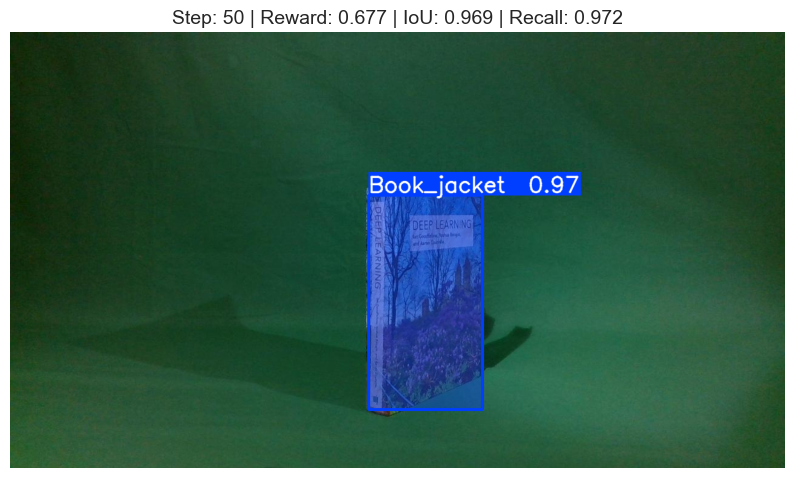

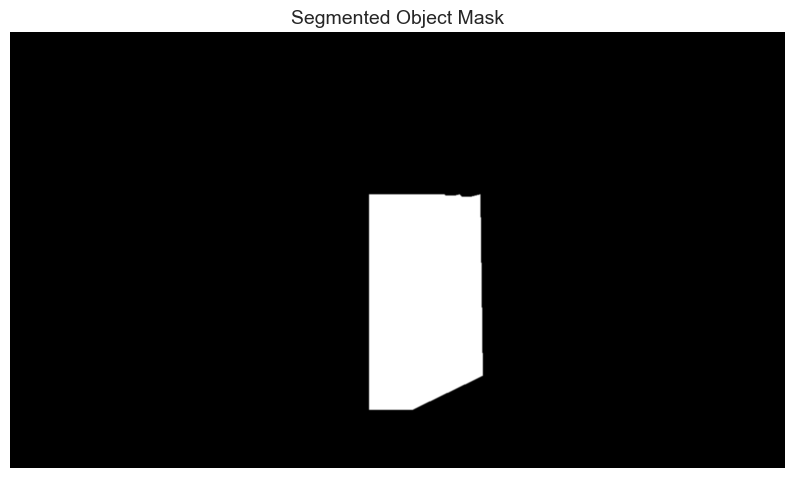

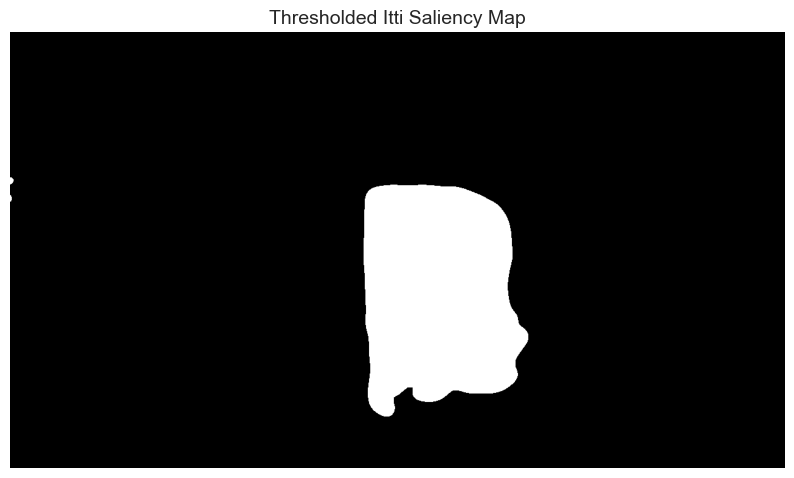

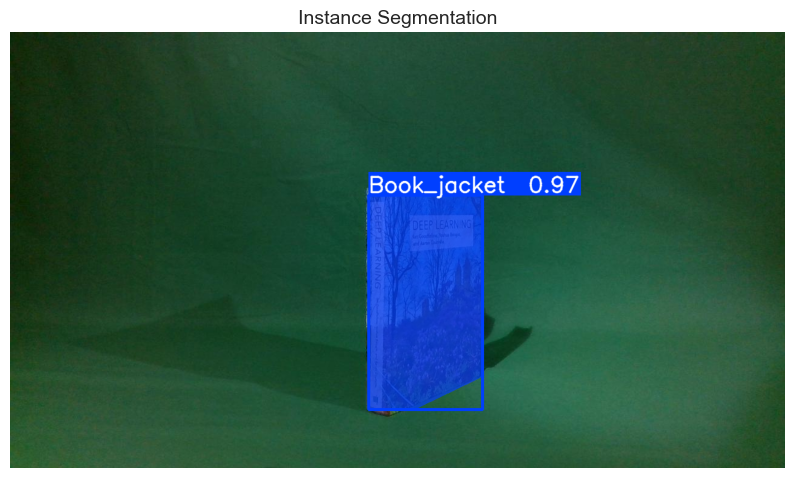

In [40]:
prediction = env.predict()
mask = env.segment(do_display=True)
mask = env.segment(do_display=True, display_mode='image')

Executing COCO

 Annotating image:  Mask Name


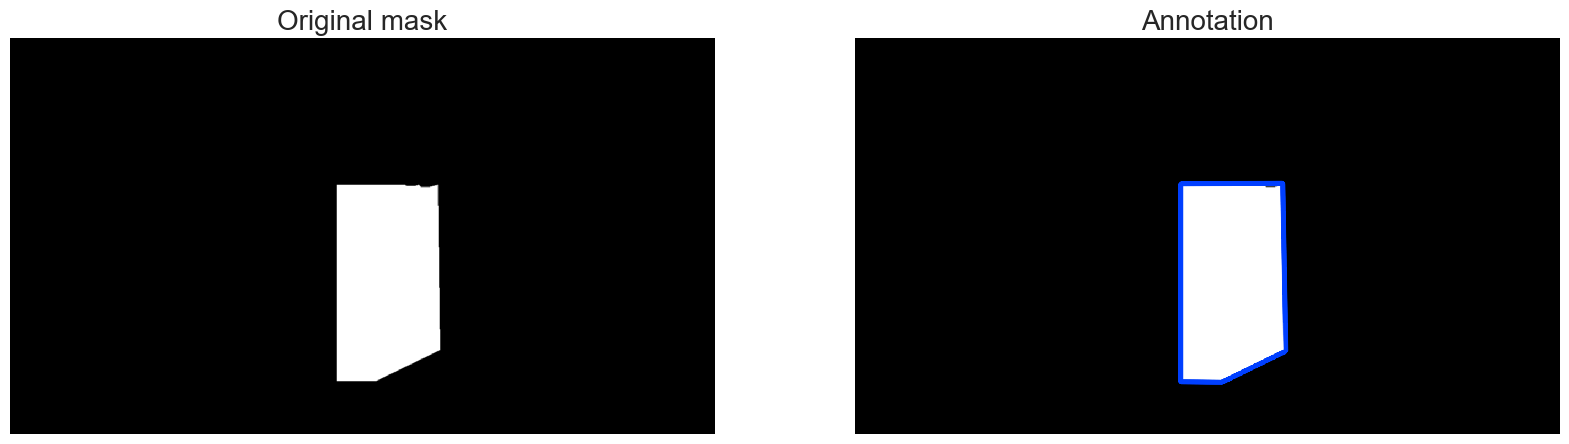

 Succesfully saved image:  Mask Name 


------------------------------------------------------------------------------------------------------------------------
Executing VGG

 Annotating image:  Mask Name


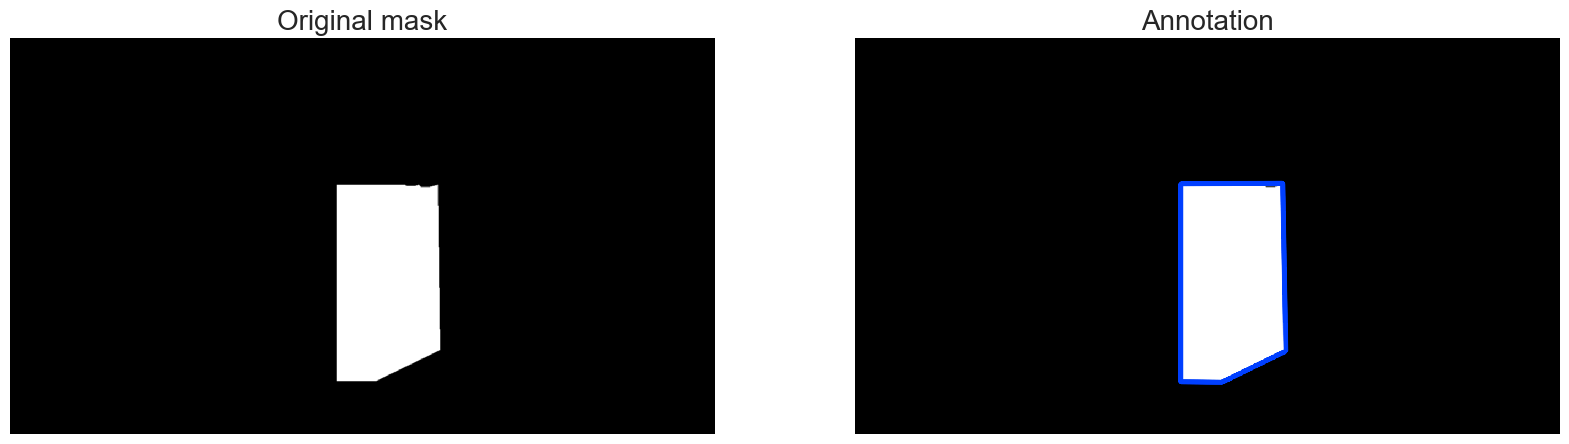

 Succesfully saved image:  Mask Name 


------------------------------------------------------------------------------------------------------------------------
Executing YOLO

 Annotating image:  Mask Name


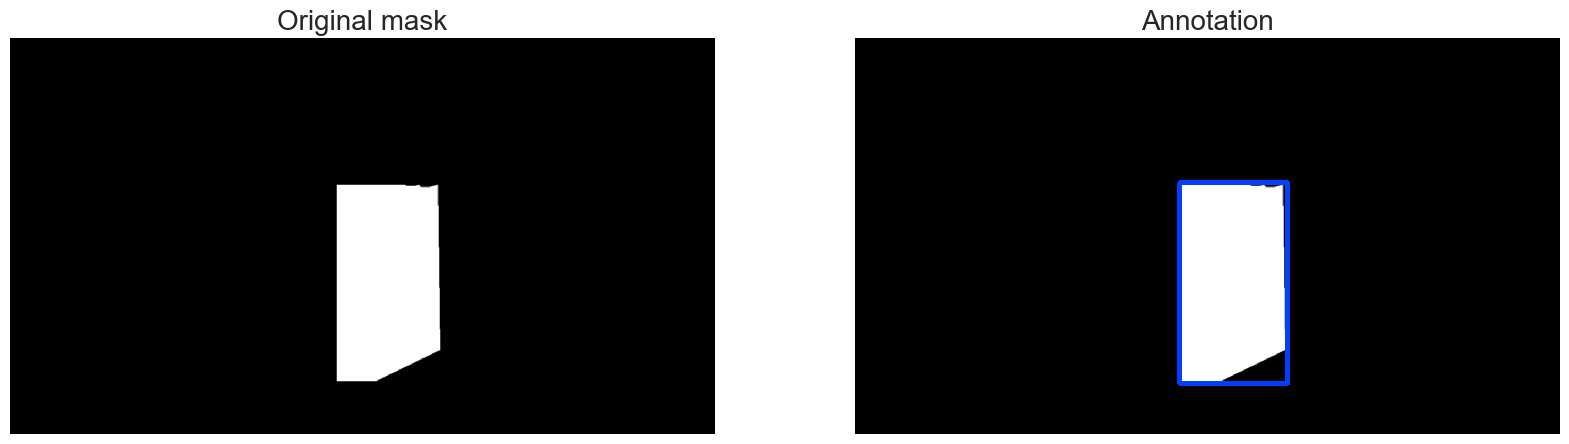

 Succesfully saved image:  Mask Name 


------------------------------------------------------------------------------------------------------------------------


In [41]:
# Applying Mask to Annotation
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

print('\033[32m' + "Executing COCO" + '\033[0m')
env.annotate(mask, "Mask Id", "Mask Name" ,"Object Detection", "Annotations/COCO_annotations", do_display=True, annotation_format="coco", do_save=True)
print('\033[32m' + "Executing VGG" + '\033[0m')
env.annotate(mask, "Mask Id", "Mask Name" ,"Object Detection", "Annotations/VGG_annotations", do_display=True, annotation_format="vgg", do_save=True)
print('\033[32m' + "Executing YOLO" + '\033[0m')
env.annotate(mask, "Mask Id", "Mask Name" ,"Object Detection", "Annotations/YOLO_annotations", do_display=True, annotation_format="yolo", do_save=True)

USE IOU FOR CROPPPING EXPERIMENT IOU WITH THE GROUND TRUTH BOUNDING BOX VS IOU WITH SARA FROM GENERATED BOUNDING BOXES WITH COCO DATASET

In [42]:
# # Predicting the bounding box with a different network
# env.reset(classifier=MobileNetV2(), target_size=MOBILENETV2_TARGET_SIZE)
# env.display(do_display=True, mode='image')
# state = env.get_state()

# total_reward = 0

# terminated = False
# truncated = False

# while True:
#     action = dqn_agent.select_action(state)
#     next_state, _, terminated, truncated, info = env.step(action)
#     env.decode_action(action)
#     done = truncated or terminated

#     state = next_state

#     env.display(do_display=True, mode='image')
#     if done:
#         break

# print(f"Total Reward: {total_reward}, IoU: {info['iou']}, Recall: {info['recall']}, Steps: {env.step_count}")
# prediction = env.predict()

In [43]:
env.close()